In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████| 9912422/9912422 [19:12<00:00, 8600.42it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 28881/28881 [00:04<00:00, 6340.40it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████| 1648877/1648877 [03:27<00:00, 7945.36it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 5033.19it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [4]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128
train_loder = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

In [6]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1) ## _ here max prob will come and we don't require it now
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [7]:
class MnistModel(nn.Module):
    def __init__(self,input_size,hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
    def forward(self,xb):
        xb = xb.view(xb.size(0),-1) ## same as .reshape()
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [8]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,hidden_size = 32,out_size = num_classes)

In [9]:
model.parameters

<bound method Module.parameters of MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)>

In [10]:
torch.cuda.is_available()

False

Images Shape: torch.Size([128, 1, 28, 28])


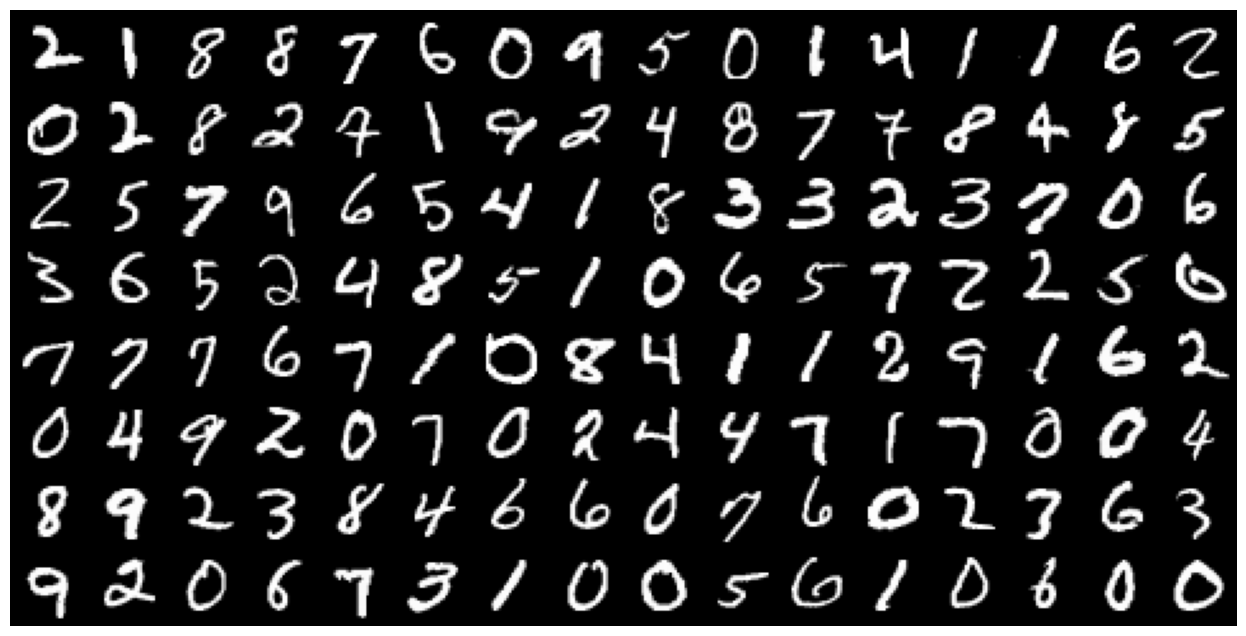

In [11]:
for images,_ in train_loder:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
def to_device(data,device):
    if isinstance(data, (list,tuple)): #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [15]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)

In [16]:
train_loder = DeviceDataLoader(train_loder,device)
val_loader = DeviceDataLoader(val_loader,device)

In [17]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [18]:
def fit(epochs,lr,model,train_loder,val_loader,opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_loder:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()#used to update the parameters
            optimizer.zero_grad()#Clears the gradients of  optimizer
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [19]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [20]:
evaluate(model,val_loader)

{'val_loss': 2.2928709983825684, 'val_acc': 0.10878164321184158}

In [21]:
history = fit(10,0.5,model,train_loder,val_loader)

Epoch [1], val_loss: 0.2486, val_acc: 0.9251
Epoch [2], val_loss: 0.1740, val_acc: 0.9498
Epoch [3], val_loss: 0.1691, val_acc: 0.9503
Epoch [4], val_loss: 0.1540, val_acc: 0.9551
Epoch [5], val_loss: 0.1444, val_acc: 0.9566
Epoch [6], val_loss: 0.1551, val_acc: 0.9538
Epoch [7], val_loss: 0.1349, val_acc: 0.9591
Epoch [8], val_loss: 0.1245, val_acc: 0.9641
Epoch [9], val_loss: 0.1408, val_acc: 0.9601
Epoch [10], val_loss: 0.1436, val_acc: 0.9616


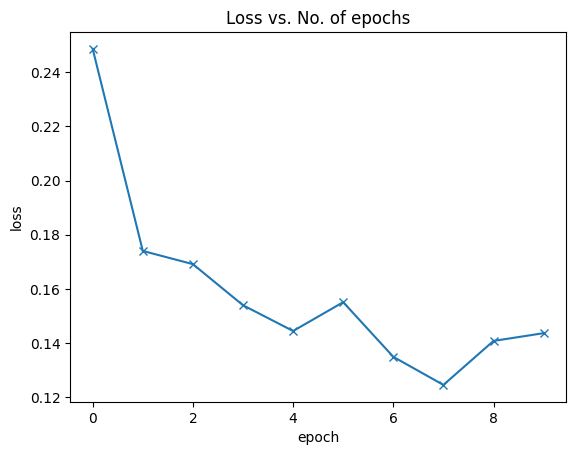

In [22]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

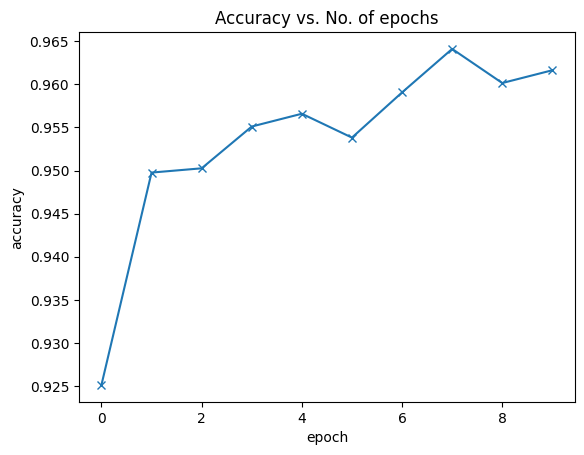

In [23]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');